In [1]:
def worker(order):
    rows, trace = order
    ans = np.zeros((len(rows), 5))
    for i, r in enumerate(rows):
        mtrace = trace[r[0]: r[1]]
        ans[i, :] = [mtrace.mean(), np.median(mtrace), np.std(mtrace), mtrace.min(), mtrace.max()]
    return ans

def regionprops1d(mask, *_trace, n_proc=1):
    """
    :param mask: 1d numpy array mask of bool, or [0,1]
    :param _trace: traces to process for stats (max, min, std, median, mean)
    :param n_proc: number of processes to spawn while calculating stats for traces
    :return: DataFrame with indices Onset (inclusive), Offset (exclusive), Length (absolute)
             When given _trace, also calculated Min, Max, STD, Median, and Mean for each trace
    """

    assert (len(mask.shape) == 1), 'shape mismatch, mask should be 1d'

    col_names = ['Onset', 'Offset', 'Length']

    if not (mask.any()):
        return None

    diff_mask = np.diff(mask, axis=-1, prepend=0, append=0)
    t_start = np.where(diff_mask == 1)[0]
    t_stop = np.where(diff_mask == -1)[0]
    assert (len(t_start) == len(t_stop))

    res = np.vstack([t_start, t_stop, t_stop - t_start]).T
    df_res = pd.DataFrame(res, columns=col_names, dtype=int)

    for itr, trace in enumerate(_trace):
        assert(len(trace) == len(mask)), f'trace len = {len(trace)} not equal to mask len = {len(mask)}'

        order = [(s, trace) for s in np.array_split(res, n_proc, axis=0)]

        if itr:
            cols = list(map(lambda x: f'{x}_{itr}', ['Mean', 'Median', 'STD', 'Min', 'Max']))
        else:
            cols = ['Mean', 'Median', 'STD', 'Min', 'Max']

        if n_proc > 1:
            with Pool(n_proc) as p:
                ans = pd.DataFrame(np.vstack(p.map(worker, order)), columns=cols)
        else:
            ans = pd.DataFrame(np.vstack(list(map(worker, order))), columns=cols)

        df_res = pd.merge(left=df_res, right=ans, left_index=True, right_index=True)

    return df_res

In [2]:
import pandas as pd
from scipy.io import loadmat
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import os

In [3]:
%matplotlib inline

In [6]:
files = !ls data_8ch_EMG/*.mat
df_data = pd.DataFrame({'mat':files})
df_data

,mat
0,data_8ch_EMG/export1_13Nov07.mat
1,data_8ch_EMG/export1_15Jan08.mat
2,data_8ch_EMG/export1_15Nov07.mat
3,data_8ch_EMG/export1_19Dec07.mat
4,data_8ch_EMG/export1_20Dec07.mat
5,data_8ch_EMG/export1_21Dec07.mat
6,data_8ch_EMG/export1_24Jan08.mat
7,data_8ch_EMG/export1_2Jan08.mat
8,data_8ch_EMG/export1_30Nov07.mat
9,data_8ch_EMG/export1_3Jan08.mat


# Single subject

In [7]:
matfile = df_data.mat.loc[0]
print(matfile)
mat = loadmat(matfile)

data_8ch_EMG/export1_13Nov07.mat


## Preprocess

In [8]:
raw = mne.io.RawArray(np.concatenate([mat['export_EMG'], 
                mat['export_X'], 
                mat['export_Y'], 
                mat['export_OnPaper'], 
                mat['export_Type'], 
                mat['export_Trial']], axis=-1).T,
               mne.create_info(['emg%i'%i for i in range(8)] + ['X', 'Y', 'OnPaper', 'Type', 'Trial'], 
                               sfreq=1000,
                               ch_types=['emg']*8+['misc']*2+['stim']*3))

raw.apply_hilbert(picks='emg', envelope=True)
raw.filter(0, 5, picks=['emg', 'misc']);
raw.resample(10);

xmin, ymin = raw.get_data(picks=['X', 'Y']).min(-1)
xmax, ymax = raw.get_data(picks=['X', 'Y']).max(-1)

Creating RawArray with float64 data, n_channels=13, n_times=3234809
    Range : 0 ... 3234808 =      0.000 ...  3234.808 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 5.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Filter length: 1651 samples (1.651 sec)

648 events found
Event IDs: [1]
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
9 events found
Event IDs: [ 2  3  4  5  6  7  8  9 10]
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
498 events fo

## OnPaper Decimation

Text(0.5, 1.0, 'Finding OnPaper threshold')

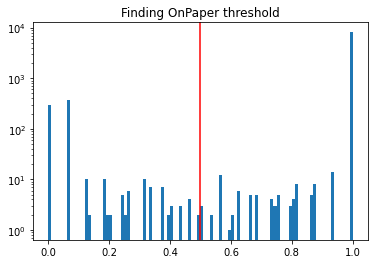

In [9]:
trace = raw.get_data(picks=['OnPaper'])[0]

plt.figure()
plt.hist(trace[trace>0], bins=100)
plt.axvline(0.5, color='r')
plt.yscale('log')
plt.title('Finding OnPaper threshold')

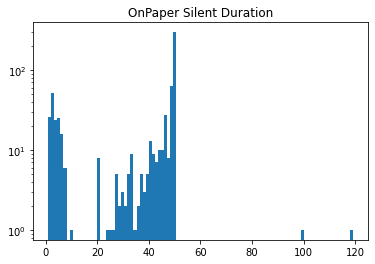

In [10]:
df_onpaper_silent = regionprops1d(trace<0.5)

plt.figure()
plt.hist(df_onpaper_silent["Length"], bins=100)
plt.title('OnPaper Silent Duration')
plt.yscale('log')

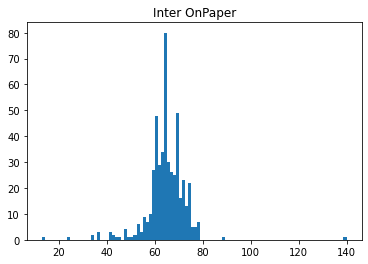

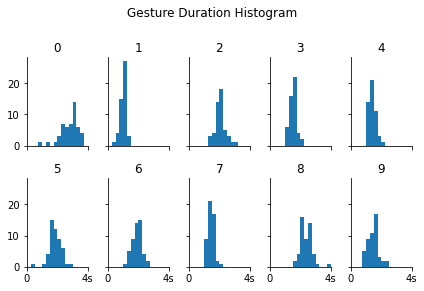

In [11]:
from scipy.ndimage import binary_closing
OnPaperMask = binary_closing(trace>0.5, structure=np.ones(10))

df_onpaper = regionprops1d(OnPaperMask, raw.get_data(picks=['Type'])[0,:])
df_onpaper.drop(columns=['Mean', 'STD', 'Min', 'Max'], inplace=True)
df_onpaper.rename(columns={'Median': 'Type'}, inplace=True)

plt.figure()
plt.hist(df_onpaper.Onset.diff(), bins=100)
plt.title('Inter OnPaper')

fig, axx = plt.subplots(2, 5, figsize=(6,4), sharex=True, sharey=True)
for i, (ax, (g_name, g)) in enumerate(zip(axx.reshape(-1), df_onpaper.groupby('Type'))):
    plt.sca(ax)
    plt.hist(g.Length/raw.info['sfreq'], bins=np.arange(0, 4.1, 0.25))
#     plt.text(4, np.mean(plt.ylim()), f'{g_name-1:.0f}', fontsize=30, rotation=0, va='center')
    plt.title(i)
    if (i in np.arange(5,10)):
#         plt.xlabel('s')
        plt.xticks([0, 4], [0, '4s'])
    plt.xlim(0, 4)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
plt.suptitle('Gesture Duration Histogram', y=1)

plt.tight_layout()

plt.savefig(os.path.join('figures', 'individual subject gesture duration.pdf'))
plt.savefig(os.path.join('figures', 'individual subject gesture duration.png'))

## Trial Events

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
498 events found
Event IDs: [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 2

Text(0.5, 1.0, 'Intertrial delay')

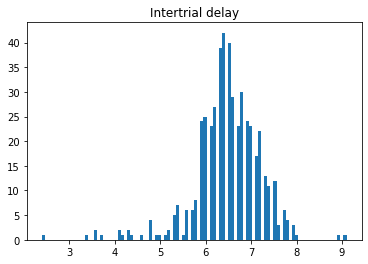

In [12]:
events = mne.find_events(raw, stim_channel='Trial')

plt.figure()
plt.hist(np.diff(events[:,0])/raw.info['sfreq'], bins=100)
plt.title('Intertrial delay')

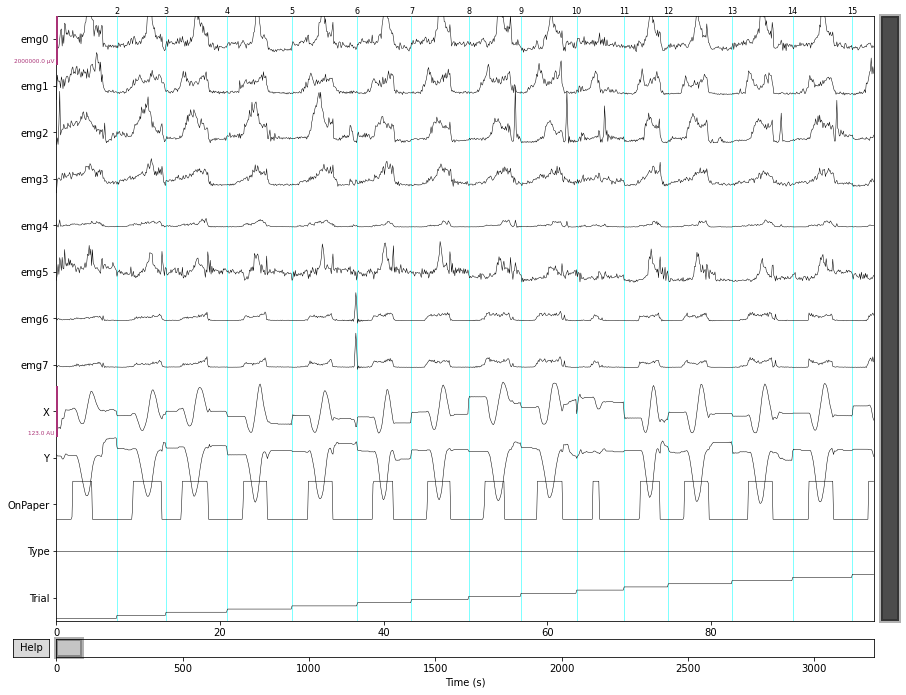

In [13]:
raw.plot(scalings={'emg':1},
         events = events,
         duration=100);

## Center events on OnPaper onset

In [14]:
events = mne.find_events(raw, stim_channel='Trial')
epochs = mne.Epochs(raw, events=events, tmin=0, tmax=5, preload=False, picks='all', baseline=None)
epochs.events[:,-1] = np.median(epochs.get_data(picks=['Type']), -1).reshape(-1).astype(int)

df_events = pd.DataFrame(epochs.events, columns=['ts', 'idx', 'code'])
print(df_events.shape)

s_shifts = pd.DataFrame(np.where(np.diff(epochs.get_data(picks=['OnPaper'])[:,0,:], axis=-1)>0.5)).T.groupby(0)[1].min()
s_shifts.name = 'shift'

df_events = pd.merge(df_events, s_shifts, left_index=True, right_index=True)

df_events.ts += df_events['shift']

on_paper_events = df_events.iloc[:, :3]

print(df_events.shape)

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
498 events found
Event IDs: [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 2

### On paper epochs


Not setting metadata
Not setting metadata
496 matching events found
No baseline correction applied
0 projection items activated
Loading data for 496 events and 51 original time points ...
0 bad epochs dropped


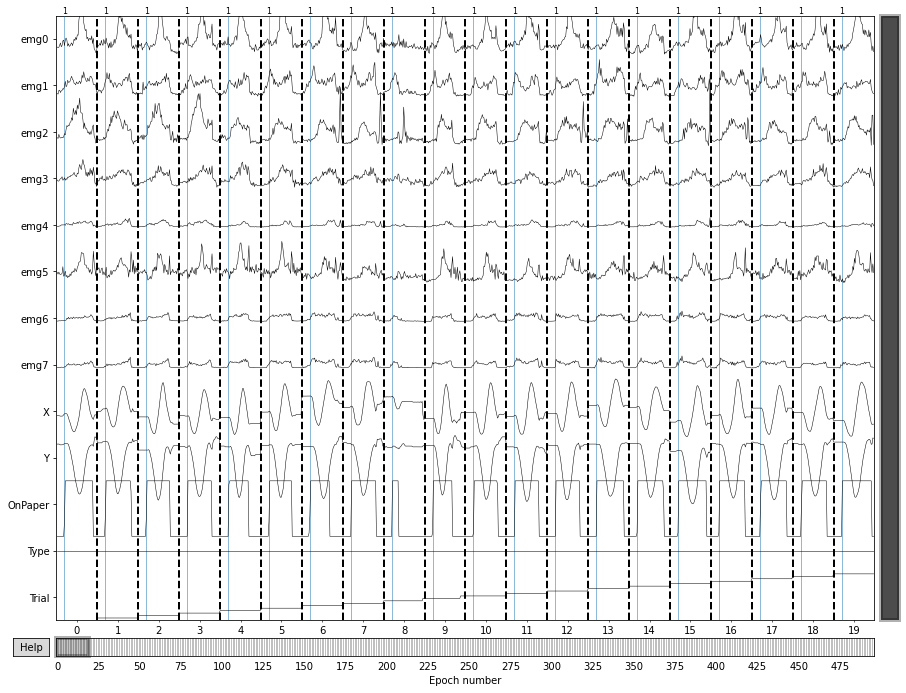

In [15]:
epochs = mne.Epochs(raw, events=on_paper_events, 
                    tmin=-1, tmax=4,
                    preload=True, picks='all', baseline=None)

epochs.plot(scalings={'emg':1}, 
            picks='all', 
            events=epochs.events);

## Gesture Duration

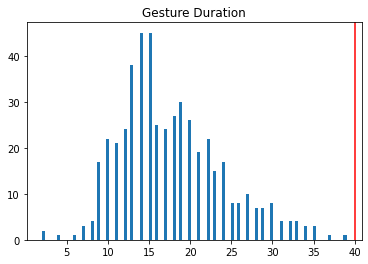

In [16]:
offsets = pd.DataFrame(np.where(np.diff(epochs.get_data(picks=['OnPaper'])[:,0,:], axis=-1)<-0.5), 
                       index=('epoch', 'ts')).T.groupby('epoch').max()-10
plt.figure()
plt.hist(offsets, bins=100)
plt.title('Gesture Duration')
plt.axvline(4*epochs.info['sfreq'], color='r')

assert(offsets.ts.max()<40)

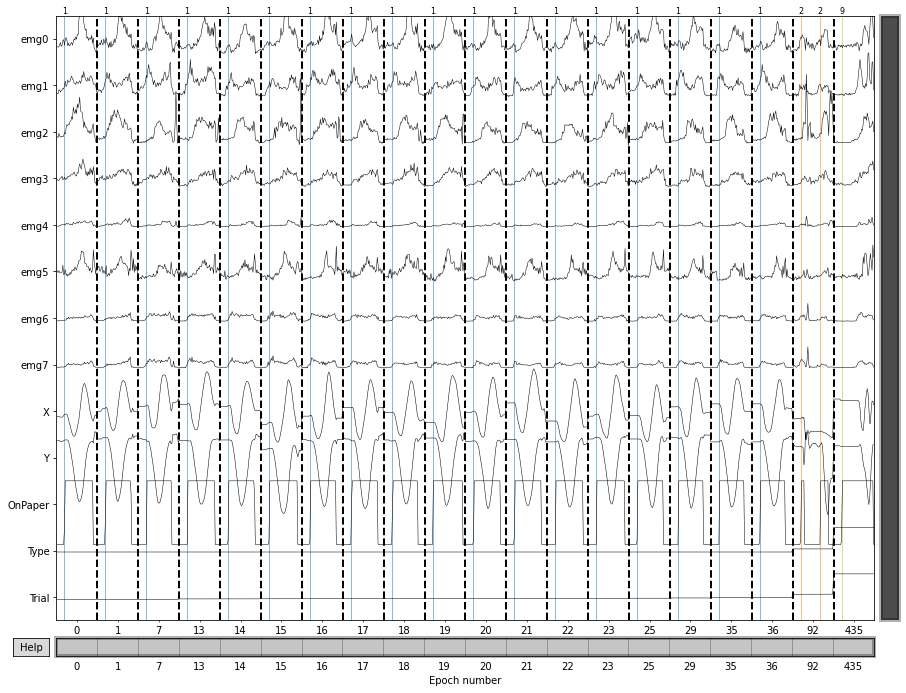

In [17]:
epochs[offsets.ts>30].plot(scalings={'emg':1}, 
            picks='all', 
            events=epochs.events);

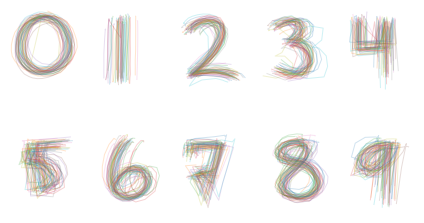

In [43]:
fig, axx = plt.subplots(2, 5, sharex=True, sharey=True)

for i, (k, ax) in enumerate(zip(epochs.event_id.keys(), axx.reshape(-1))):
    plt.sca(ax)
    for X, Y, OnPaper in epochs[k].get_data(['X', 'Y', 'OnPaper']):
        mask = OnPaper>0.5
        plt.plot(X[mask], Y[mask], alpha=0.2, lw=1)
        plt.axis('image')
    
#     plt.xlim(xmin, xmax)
#     plt.ylim(ymin, ymax)
#     plt.title(k-1)
    plt.axis('off')
#     break
    
plt.tight_layout()

plt.savefig(os.path.join('figures', 'individual xy traces.pdf'))
plt.savefig(os.path.join('figures', 'individual xy traces.png'))

### Scaling test

In [31]:
# for later, just skip it

def scaler(x,y,mask_d):
    coordinates_X = pd.DataFrame(np.stack(x.values()))
    coordinates_Y = pd.DataFrame(np.stack(y.values()))
    mask = pd.DataFrame(np.stack(mask_d.values()))
    X_center = np.min(coordinates_X, axis=1) + ((np.max(coordinates_X, axis=1) - np.min(coordinates_X, axis=1)) / 2)
    X_range = np.max(coordinates_X, axis=1) - np.min(coordinates_X, axis=1)
    Y_center = np.min(coordinates_Y, axis=1) + ((np.max(coordinates_Y, axis=1) - np.min(coordinates_Y, axis=1)) / 2)
    Y_range = np.max(coordinates_Y, axis=1) - np.min(coordinates_Y, axis=1)
#     x_to_draw = []
#     y_to_draw = []

#     (coordinates_X.loc[i][mask.loc[i]] - X_center[i]) / X_range[i]
#     (coordinates_Y.loc[i][mask.loc[i]] - Y_center[i]) / Y_range[i]
    x_to_draw = []
    y_to_draw = []
    for i, _ in coordinates_X.iterrows():
        for j in range(len(mask.loc[i])):
            if mask.loc[i][j]:
                x_to_draw.append((coordinates_X.loc[i][j] - X_center[i])/X_range[i])
                y_to_draw.append((coordinates_Y.loc[i][j] - Y_center[i])/Y_range[i])
    return x_to_draw, y_to_draw

/Users/Lellight/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


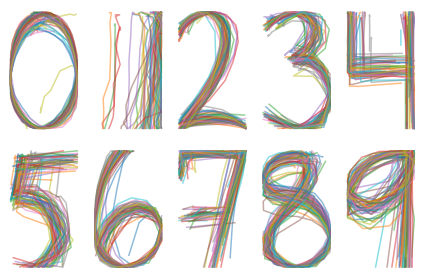

In [44]:
fig, axx = plt.subplots(2, 5, sharex=True, sharey=True)

for l, (k, ax) in enumerate(zip(epochs.event_id.keys(), axx.reshape(-1))):
    plt.sca(ax)
    Y_d = {}
    X_d = {}
    mask_d = {}
    for n, (X, Y, OnPaper) in enumerate(epochs[k].get_data(['X', 'Y', 'OnPaper'])):
        mask = OnPaper>0.5
        mask_d[n] = mask
        Y_d[n] = Y
        X_d[n] = X
        
    
      
    coordinates_X = pd.DataFrame(np.stack(X_d.values()))
    coordinates_Y = pd.DataFrame(np.stack(Y_d.values()))
    mask = pd.DataFrame(np.stack(mask_d.values()))
    X_center = np.min(coordinates_X, axis=1) + ((np.max(coordinates_X, axis=1) - np.min(coordinates_X, axis=1)) / 2)
    X_range = np.max(coordinates_X, axis=1) - np.min(coordinates_X, axis=1)
    Y_center = np.min(coordinates_Y, axis=1) + ((np.max(coordinates_Y, axis=1) - np.min(coordinates_Y, axis=1)) / 2)
    Y_range = np.max(coordinates_Y, axis=1) - np.min(coordinates_Y, axis=1)
    x_to_draw = []
    y_to_draw = []

#     (coordinates_X.loc[i][mask.loc[i]] - X_center[i]) / X_range[i]
#     (coordinates_Y.loc[i][mask.loc[i]] - Y_center[i]) / Y_range[i]
    for i, _ in coordinates_X.iterrows():
#     x_to_draw = []
#     y_to_draw = []
        for j in range(len(mask.loc[i])):
            if mask.loc[i][j]:
                x_to_draw.append((coordinates_X.loc[i][j] - X_center[i])/X_range[i])
                y_to_draw.append((coordinates_Y.loc[i][j] - Y_center[i])/Y_range[i])
                
            else:
                ax.plot(x_to_draw, y_to_draw, color=sns.color_palette()[i % 10], alpha=0.5)
                x_to_draw = []
                y_to_draw = []
                
    plt.plot(x_to_draw, y_to_draw, alpha=0.2, lw=1)
    plt.axis('off')
    
plt.tight_layout()

plt.savefig(os.path.join('figures', 'individual xy traces scaled.pdf'))
plt.savefig(os.path.join('figures', 'individual xy traces scaled.png'))

## Decomposition

In [46]:
epochs = mne.Epochs(raw, events=on_paper_events, 
                    tmin=0, tmax=4,
                    preload=True, picks='all', baseline=None)

X = epochs.get_data(picks='emg').reshape(len(epochs), -1)
y = epochs.events[:, -1]

Not setting metadata
Not setting metadata
496 matching events found
No baseline correction applied
0 projection items activated
Loading data for 496 events and 41 original time points ...
0 bad epochs dropped


In [48]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pipe = Pipeline([('PCA', PCA(n_components=25)), 
                 ('TSNE', TSNE(n_components=2, perplexity=30))])
tv = pipe.fit_transform(X)

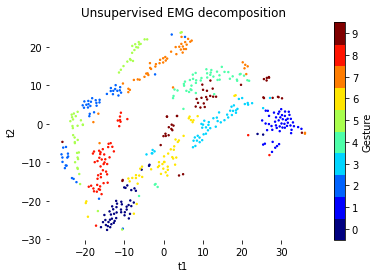

In [49]:
plt.figure()
s = plt.scatter(*(tv.T), c=y-1, s=2, cmap=plt.get_cmap('jet', 10), vmin=-0.5, vmax=9.5)
c = plt.colorbar()
c.set_label('Gesture')
c.set_ticks(np.arange(10))
plt.box(False)

plt.title('Unsupervised EMG decomposition')
plt.xlabel('t1')
plt.ylabel('t2')

plt.savefig(os.path.join('figures', 'EMG decomposition.pdf'))
plt.savefig(os.path.join('figures', 'EMG decomposition.png'))

### EMG figure

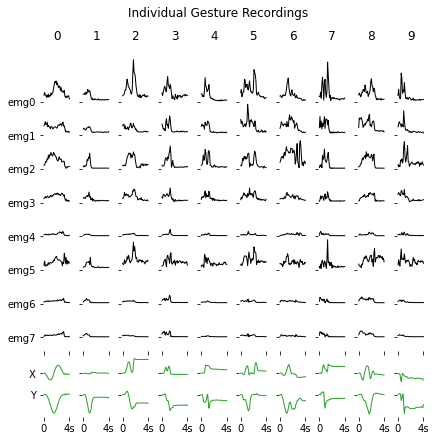

In [50]:
fig, axxx = plt.subplots(2, 10, sharex=True, sharey='row', gridspec_kw={'height_ratios':[5, 1]}, figsize=(6,6))
data = epochs[[1, 52, 101, 151, 201, 251, 301, 351, 401, 451]].get_data(picks=np.arange(10))
for i, (axx, d) in enumerate(zip(axxx.T, data)):
    ax = axx[0]
    plt.sca(ax)
    plt.plot(epochs.times, d[:8].T/3 - np.arange(8), color='k', lw=1)
    if i == 0:
        plt.yticks(-np.arange(8), epochs.ch_names[:8])
    plt.box(False)
    plt.title(i)
    
    ax = axx[1]
    plt.sca(ax)
    plt.plot(epochs.times, (d[8:]-d[8:,[0]]).T/150 - np.arange(2), color='C2', lw=1)
    if i == 0:
        plt.yticks(-np.arange(2), ['X', 'Y'])
        
    plt.xticks([0, 4], [0, '4s'])
    plt.box(False)
plt.suptitle('Individual Gesture Recordings', y=1)
plt.tight_layout(pad=.5)

plt.savefig(os.path.join('figures', 'individual emg.pdf'))
plt.savefig(os.path.join('figures', 'individual emg.png'))

## Classifier

In [51]:
from sklearn.model_selection import train_test_split

epochs = mne.Epochs(raw, events=on_paper_events, 
                    tmin=-1, tmax=4,
                    preload=True, picks='all', baseline=None)
epochs.events[:,-1] -=1

X = epochs.get_data(picks='emg')
y = epochs.events[:,-1].astype(int)-1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)
print('Train', X_train.shape, 'Test', X_test.shape)

Not setting metadata
Not setting metadata
496 matching events found
No baseline correction applied
0 projection items activated
Loading data for 496 events and 51 original time points ...
0 bad epochs dropped
Train (396, 8, 51) Test (100, 8, 51)


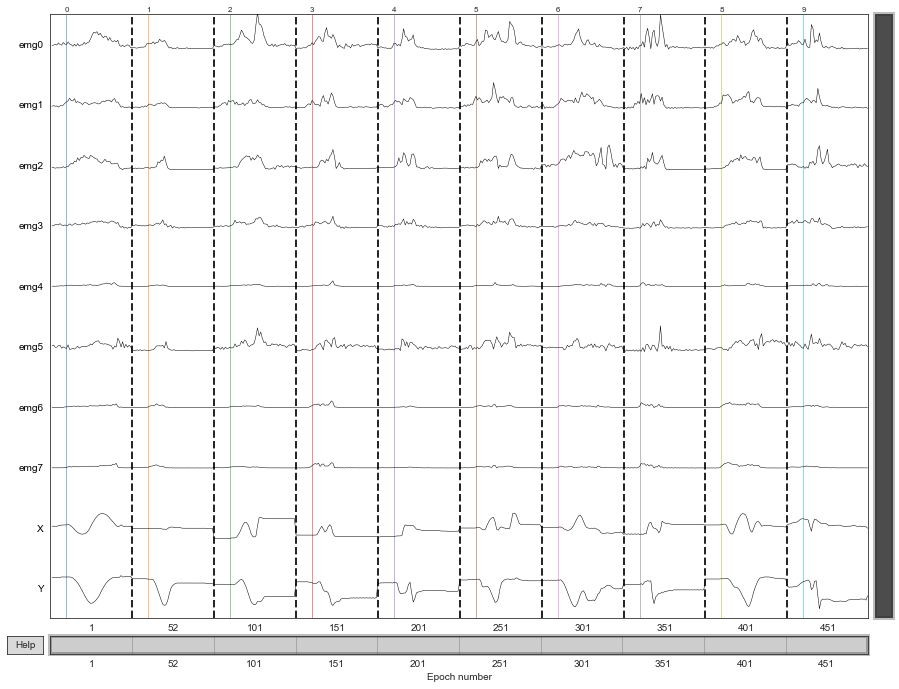

In [421]:
epochs[[1, 52, 101, 151, 201, 251, 301, 351, 401, 451]].plot(scalings={'emg':3, 
                                                                       'misc':150}, 
                                                             picks=np.arange(10), 
                                                             events=epochs.events);

## Dataset

In [52]:
from sklearn.model_selection import train_test_split

epochs = mne.Epochs(raw, events=on_paper_events, 
                    tmin=-1, tmax=4,
                    preload=True, picks='all', baseline=None)

X = epochs.get_data(picks='emg')
y = epochs.events[:,-1].astype(int)-1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)
print('Train', X_train.shape, 'Test', X_test.shape)

Not setting metadata
Not setting metadata
496 matching events found
No baseline correction applied
0 projection items activated
Loading data for 496 events and 51 original time points ...
0 bad epochs dropped
Train (396, 8, 51) Test (100, 8, 51)


In [53]:
import torch
from torch.utils.data import Dataset, DataLoader

class GestureDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return(len(self.X))
        
    def __getitem__(self, idx):
        sample = np.swapaxes(self.X[idx][..., np.newaxis, :, :], -1, -2)
        label  = self.y[idx]
        if self.transform:
            sample = self.transform(sample).double()
        return sample, label
        

In [481]:
from torch import functional as F
from torch import nn
sequence_length = len(epochs.times)
input_size  = 8
num_filters = 32
hidden_size = 32
num_layers  = 2
num_classes = 10
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    
    def __init__(self, input_size, num_filters, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_filters = num_filters
        
        self.cnn1 = nn.Conv2d(in_channels=1, 
                              out_channels=num_filters, 
                              kernel_size=(1, input_size), 
                              stride=1, 
                              padding=0)
        
        
        
        
        self.ap1 = nn.AvgPool2d(3, stride=2)
        
        self.cnn2 = nn.Conv2d(in_channels=num_filters,
                              out_channels=64,
                              
                              kernel_size=(1, input_size), stride=1)
        
        self.ap2 = nn.AvgPool2d(3, stride=2)
        
        self.cnn3 = nn.Conv2d(in_channels=64, 
                             out_channels=128,
                             kernel_size=(1, input_size), stride=1)
        
        self.ap3 = nn.AvgPool2d(3, stride=2)
        
        self.do1 = nn.Dropout2d(p=0.5)
        
        self.flat = nn.Flatten()
        
#         self.fc0 = nn.Linear(in_features=128, out_features=256)
        
        self.relu1 = nn.ReLU()
        
        self.do2 = nn.Dropout2d(p=0.5)
        
#         self.fc1 = self.Linear(in_features=128, out_features=256)
        
        self.sig = nn.Sigmoid()
        
        self.lstm2 = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True, dropout=0.5)

#         self.relu2 = nn.ReLU()
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        
        out = self.relu1(self.do1(self.cnn1(x)))
        out = torch.transpose(out, 1, 2)[..., 0]
        
        out, hidden = self.lstm2(out, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
#         out = self.relu2(out)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :]) # taking the last one in the sequence
        return out
       
        pass
pass
model = RNN(input_size, num_filters, hidden_size, num_layers, num_classes).to(device)
print(model)

RNN(
  (cnn1): Conv2d(1, 32, kernel_size=(1, 8), stride=(1, 1))
  (ap1): AvgPool2d(kernel_size=3, stride=2, padding=0)
  (cnn2): Conv2d(32, 64, kernel_size=(1, 8), stride=(1, 1))
  (ap2): AvgPool2d(kernel_size=3, stride=2, padding=0)
  (cnn3): Conv2d(64, 128, kernel_size=(1, 8), stride=(1, 1))
  (ap3): AvgPool2d(kernel_size=3, stride=2, padding=0)
  (do1): Dropout2d(p=0.5, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (relu1): ReLU()
  (do2): Dropout2d(p=0.5, inplace=False)
  (sig): Sigmoid()
  (lstm2): LSTM(32, 32, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)


## Single Run

In [ ]:
input_size  = 8
num_filters = 32
hidden_size = 32
num_layers  = 2
num_classes = 10

Train (396, 8, 51) Test (100, 8, 51)


Epoch [30/3000], Step [1], Loss: 1.94e+00, Val: 1.99e+00, Accuracy: 0.27 vs 0.25
Epoch [60/3000], Step [1], Loss: 1.43e+00, Val: 1.58e+00, Accuracy: 0.40 vs 0.35
Epoch [90/3000], Step [1], Loss: 1.14e+00, Val: 1.47e+00, Accuracy: 0.52 vs 0.47
Epoch [120/3000], Step [1], Loss: 9.86e-01, Val: 1.08e+00, Accuracy: 0.64 vs 0.59
Epoch [150/3000], Step [1], Loss: 6.79e-01, Val: 8.43e-01, Accuracy: 0.76 vs 0.68
Epoch [180/3000], Step [1], Loss: 5.50e-01, Val: 6.61e-01, Accuracy: 0.81 vs 0.77
Epoch [210/3000], Step [1], Loss: 4.72e-01, Val: 8.21e-01, Accuracy: 0.82 vs 0.78
Epoch [240/3000], Step [1], Loss: 3.42e-01, Val: 4.36e-01, Accuracy: 0.89 vs 0.89
Epoch [270/3000], Step [1], Loss: 2.35e-01, Val: 5.28e-01, Accuracy: 0.91 vs 0.86
Epoch [300/3000], Step [1], Loss: 1.89e-01, Val: 5.77e-01, Accuracy: 0.94 vs 0.83
Epoch [330/3000], Step [1], Loss: 1.43e-01, Val: 4.39e-01, Accuracy: 0.96 vs 0.89
Epoch [360/3000], Step [1], Loss: 1.35e-01, Val: 4.53e-01, Accuracy: 0.94 vs 0.86
Epoch [390/3000], S

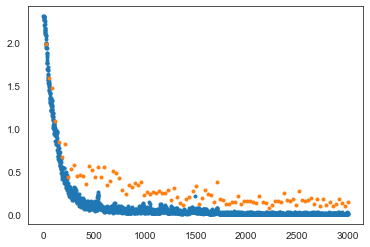

In [482]:
from tqdm.autonotebook import tqdm

criterion = nn.CrossEntropyLoss()
softmax = nn.Softmax(1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)   
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)
print('Train', X_train.shape, 'Test', X_test.shape)


train_loader = DataLoader(GestureDataset(X_train, y_train, transform=torch.from_numpy),
                          batch_size = len(y_train), 
                          shuffle = True)

test_loader = DataLoader(GestureDataset(X_test, y_test, transform=torch.from_numpy),
                          batch_size = len(y_test), 
                          shuffle = True)

num_epochs = 3000

plt.figure()

test_accs = []
for epoch in tqdm(range(num_epochs)):
    for i, (samples, labels) in enumerate(train_loader):
        samples = samples.to(device).float()
        labels = labels.to(device)

        # Forward pass
        outputs = model(samples)
        acc = (outputs.argmax(-1) == labels).cpu().numpy().mean()
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    plt.plot(epoch, loss.item(), '.', color='C0')

    if (epoch+1) % (num_epochs//100) == 0:
        with torch.no_grad():
            for i, (samples, labels) in enumerate(test_loader):
                samples = samples.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model(samples)
                acc_val = (outputs.argmax(-1) == labels).cpu().numpy().mean()
                test_accs.append(acc_val)
                loss_val = criterion(outputs, labels)
                scheduler.step(loss_val)

        print ('Epoch [{}/{}], Step [{}], Loss: {:.2e}, Val: {:.2e}, Accuracy: {:.2f} vs {:.2f}' 
               .format(epoch + 1, num_epochs, i + 1, loss.item(), loss_val.item(), acc, acc_val))
        plt.plot(epoch, loss_val.item(), '.', color='C1')
        pass

    pass
pass

In [487]:
dot = make_dot(model(samples), 
         params=dict(model.named_parameters()), 
         show_attrs=False, 
         show_saved=True, )
# dot.render('figures/rnn', format='pdf') 

KeyboardInterrupt: 

## KFold run

(396,) (100,)



(397,) (99,)



(397,) (99,)



(397,) (99,)



(397,) (99,)


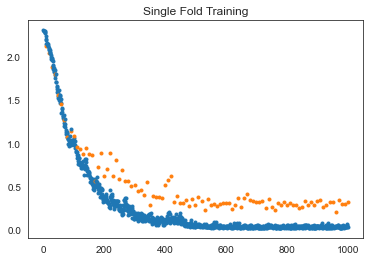

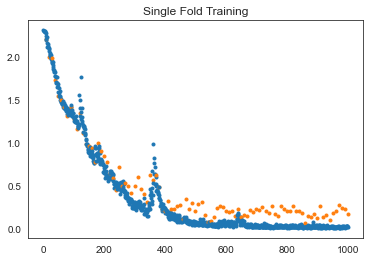

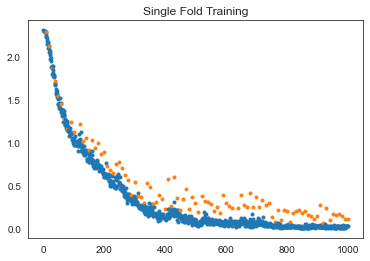

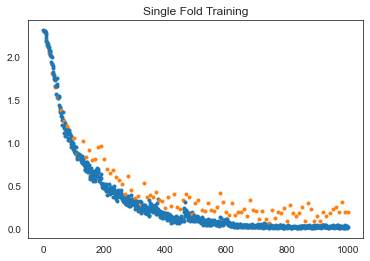

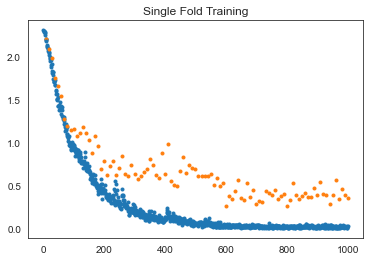

In [450]:
from tqdm.autonotebook import tqdm
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True)

metrics = {'acc_train': [], 'acc_val': [], 'loss_train': [], 'loss_val': []}

for train_index, test_index in kf.split(X, y):
    
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    print(train_index.shape, test_index.shape)
    
    train_loader = DataLoader(GestureDataset(X_train, y_train, transform=torch.from_numpy),
                              batch_size = len(y_train), 
                              shuffle = True)

    test_loader = DataLoader(GestureDataset(X_test, y_test, transform=torch.from_numpy),
                              batch_size = len(y_test), 
                              shuffle = True)

    num_epochs = 1000
    
    model = RNN(input_size, num_filters, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(1)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)  
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    plt.figure()

    loss_train_ = []
    loss_val_ = []
    acc_train_ = []
    acc_val_ = []
    
    for epoch in tqdm(range(num_epochs)):
        for i, (samples, labels) in enumerate(train_loader):
            samples = samples.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model(samples)
            acc = (outputs.argmax(-1) == labels).cpu().numpy().mean()
            acc_train_.append(acc)
            
            loss = criterion(outputs, labels)
            loss_train_.append(loss.item())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        plt.plot(epoch, loss.item(), '.', color='C0')

        if (epoch+1) % (num_epochs//100) == 0:
            with torch.no_grad():
                for i, (samples, labels) in enumerate(test_loader):
                    samples = samples.to(device).float()
                    labels = labels.to(device)

                    # Forward pass
                    outputs = model(samples)
                    acc_val = (outputs.argmax(-1) == labels).cpu().numpy().mean()
                    acc_val_.append(acc_val)
                    
                    loss_val = criterion(outputs, labels)
                    scheduler.step(loss_val)
                    loss_val_.append(loss_val.item())

#             print ('Epoch [{}/{}], Step [{}], Loss: {:.2e}, Val: {:.2e}, Accuracy: {:.2f} vs {:.2f}' 
#                    .format(epoch + 1, num_epochs, i + 1, loss.item(), loss_val.item(), acc, acc_val))
            plt.plot(epoch, loss_val.item(), '.', color='C1')
            pass

        pass
    plt.title('Single Fold Training')
    
    metrics['acc_train'].append(acc_train_)
    metrics['acc_val'].append(acc_val_)
    metrics['loss_train'].append(loss_train_)
    metrics['loss_val'].append(loss_val_)
    pass


(396,) (100,)



(397,) (99,)



(397,) (99,)



(397,) (99,)



(397,) (99,)


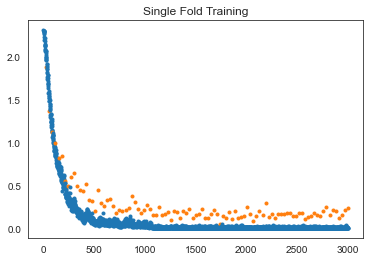

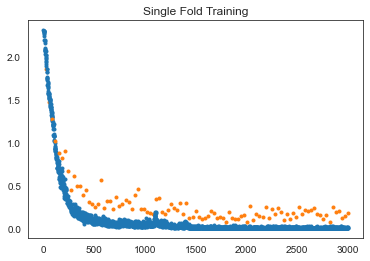

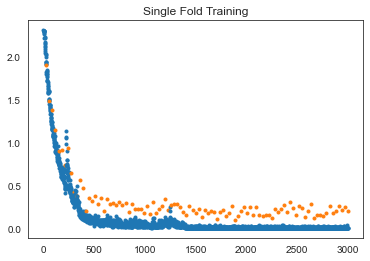

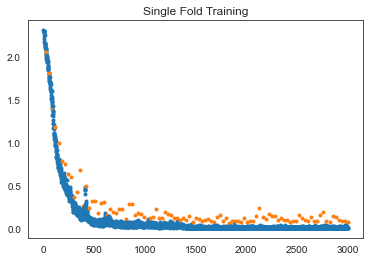

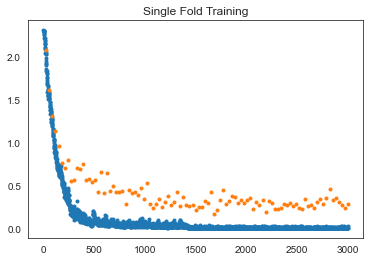

In [452]:
from tqdm.autonotebook import tqdm
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True)

metrics = {'acc_train': [], 'acc_val': [], 'loss_train': [], 'loss_val': []}

for train_index, test_index in kf.split(X, y):
    
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    print(train_index.shape, test_index.shape)
    
    train_loader = DataLoader(GestureDataset(X_train, y_train, transform=torch.from_numpy),
                              batch_size = len(y_train), 
                              shuffle = True)

    test_loader = DataLoader(GestureDataset(X_test, y_test, transform=torch.from_numpy),
                              batch_size = len(y_test), 
                              shuffle = True)

    num_epochs = 3000
    
    model = RNN(input_size, num_filters, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(1)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)  
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    plt.figure()

    loss_train_ = []
    loss_val_ = []
    acc_train_ = []
    acc_val_ = []
    
    for epoch in tqdm(range(num_epochs)):
        for i, (samples, labels) in enumerate(train_loader):
            samples = samples.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model(samples)
            acc = (outputs.argmax(-1) == labels).cpu().numpy().mean()
            acc_train_.append(acc)
            
            loss = criterion(outputs, labels)
            loss_train_.append(loss.item())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        plt.plot(epoch, loss.item(), '.', color='C0')

        if (epoch+1) % (num_epochs//100) == 0:
            with torch.no_grad():
                for i, (samples, labels) in enumerate(test_loader):
                    samples = samples.to(device).float()
                    labels = labels.to(device)

                    # Forward pass
                    outputs = model(samples)
                    acc_val = (outputs.argmax(-1) == labels).cpu().numpy().mean()
                    acc_val_.append(acc_val)
                    
                    loss_val = criterion(outputs, labels)
                    scheduler.step(loss_val)
                    loss_val_.append(loss_val.item())

#             print ('Epoch [{}/{}], Step [{}], Loss: {:.2e}, Val: {:.2e}, Accuracy: {:.2f} vs {:.2f}' 
#                    .format(epoch + 1, num_epochs, i + 1, loss.item(), loss_val.item(), acc, acc_val))
            plt.plot(epoch, loss_val.item(), '.', color='C1')
            pass

        pass
    plt.title('Single Fold Training')
    
    metrics['acc_train'].append(acc_train_)
    metrics['acc_val'].append(acc_val_)
    metrics['loss_train'].append(loss_train_)
    metrics['loss_val'].append(loss_val_)
    pass


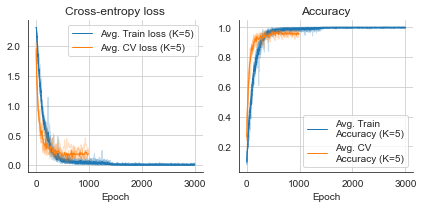

In [466]:
ep_train = np.arange(num_epochs)
ep_val = np.arange(0, num_epochs, 10)

fig, axx = plt.subplots(1,2, sharex=True, figsize=(6,3))

plt.sca(axx[0])
plt.plot(ep_train, np.array(metrics['loss_train']).T, lw=1, color='C0', alpha=0.25, label='__nolegend__')
plt.plot(ep_train, np.array(metrics['loss_train']).mean(0), lw=1, color='C0', alpha=1, label='Avg. Train loss (K=5)')

plt.plot(ep_val[:100], np.array(metrics['loss_val']).T, lw=1, color='C1', alpha=0.25, label='__nolegend__')
plt.plot(ep_val[:100], np.array(metrics['loss_val']).mean(0), lw=1, color='C1', alpha=1, label='Avg. CV loss (K=5)')
plt.legend(fontsize=10)
plt.grid(True)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Epoch')

plt.title('Cross-entropy loss')

plt.sca(axx[1])
plt.plot(ep_train, np.array(metrics['acc_train']).T, lw=1, color='C0', alpha=0.25, label='__nolegend__')
plt.plot(ep_train, np.array(metrics['acc_train']).mean(0), lw=1, color='C0', alpha=1, label='Avg. Train\nAccuracy (K=5)')

plt.plot(ep_val[:100], np.array(metrics['acc_val']).T, lw=1, color='C1', alpha=0.25, label='__nolegend__')
plt.plot(ep_val[:100], np.array(metrics['acc_val']).mean(0), lw=1, color='C1', alpha=1, label='Avg. CV\nAccuracy (K=5)')
plt.legend(fontsize=10)

plt.title('Accuracy')
plt.grid(True)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel('Epoch')

plt.tight_layout()

plt.savefig(os.path.join('figures', 'individual subject training loss.pdf'))
plt.savefig(os.path.join('figures', 'individual subject training loss.png'))


# Intersubject metrics

## Utils

In [79]:
def mat2raw(mat):
    print('Creating raw')
    raw = mne.io.RawArray(np.concatenate([mat['export_EMG'], 
                mat['export_X'], 
                mat['export_Y'], 
                mat['export_OnPaper'], 
                mat['export_Type'], 
                mat['export_Trial']], axis=-1).T,
               mne.create_info(['emg%i'%i for i in range(8)] + ['X', 'Y', 'OnPaper', 'Type', 'Trial'], 
                               sfreq=1000,
                               ch_types=['emg']*8+['misc']*2+['stim']*3),
                         verbose=0)

    raw.apply_hilbert(picks='emg', envelope=True)
    raw.filter(0, 5, picks=['emg', 'misc']);
    raw.resample(10);
    return raw

In [98]:
def centerOnPaper(raw):
    print('Centering OnPaper events')
    events = mne.find_events(raw, stim_channel='Trial', verbose=0)
    epochs = mne.Epochs(raw, events=events, tmin=0, tmax=5, preload=False, picks='all', baseline=None)
    epochs.events[:,-1] = np.median(epochs.get_data(picks=['Type']), -1).reshape(-1).astype(int)

    df_events = pd.DataFrame(epochs.events, columns=['ts', 'idx', 'code'])
    print(df_events.shape)

    s_shifts = pd.DataFrame(np.where(np.diff(epochs.get_data(picks=['OnPaper'])[:,0,:], axis=-1)>0.5)).T.groupby(0)[1].min()
    s_shifts.name = 'shift'

    df_events = pd.merge(df_events, s_shifts, left_index=True, right_index=True)

    df_events.ts += df_events['shift']

    on_paper_events = df_events.iloc[:, :3]

    print(df_events.shape)
    return on_paper_events

## Dataset class

In [99]:
import torch
from torch.utils.data import Dataset, DataLoader

class GestureDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return(len(self.X))
        
    def __getitem__(self, idx):
        sample = np.swapaxes(self.X[idx][..., np.newaxis, :, :], -1, -2)
        label  = self.y[idx]
        if self.transform:
            sample = self.transform(sample).double()
        return sample, label
        

## Model class

In [100]:
from torch import functional as F
from torch import nn
sequence_length = len(epochs.times)
input_size  = 8
num_filters = 32
hidden_size = 32
num_layers  = 2
num_classes = 10
device='cuda'

class RNN(nn.Module):
    
    def __init__(self, input_size, num_filters, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_filters = num_filters
        
        self.cnn1 = nn.Conv2d(in_channels=1, 
                              out_channels=num_filters, 
                              kernel_size=(1, input_size), 
                              stride=1, 
                              padding=0)
        
        self.do1 = nn.Dropout2d(p=0.5)
        
        self.relu1 = nn.ReLU()
        
        self.lstm2 = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True, dropout=0.5)

#         self.relu2 = nn.ReLU()
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        
        out = self.relu1(self.do1(self.cnn1(x)))
        out = torch.transpose(out, 1, 2)[..., 0]
        
        out, hidden = self.lstm2(out, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
#         out = self.relu2(out)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :]) # taking the last one in the sequence
        return out
       
        pass
pass
model = RNN(input_size, num_filters, hidden_size, num_layers, num_classes).to(device)
print(model)

RNN(
  (cnn1): Conv2d(1, 32, kernel_size=(1, 8), stride=(1, 1))
  (do1): Dropout2d(p=0.5, inplace=False)
  (relu1): ReLU()
  (lstm2): LSTM(32, 32, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)


## Run

In [103]:
from tqdm.autonotebook import tqdm
from sklearn.model_selection import StratifiedKFold

for idx_, row_ in tqdm(df_data.iterrows(), total=len(df_data)):
    matfile = row_.mat
    print('Loading', matfile)
    mat = loadmat(matfile)
    
    raw = mat2raw(mat)
    
    on_paper_events = centerOnPaper(raw)
    
    from sklearn.model_selection import train_test_split

    epochs = mne.Epochs(raw, events=on_paper_events, 
                        tmin=-1, tmax=4,
                        preload=True, picks='all', baseline=None, verbose=0)

    X = epochs.get_data(picks='emg')
    y = epochs.events[:,-1].astype(int)-1

    kf = StratifiedKFold(n_splits=5, shuffle=True)

    metrics = {'acc_train': [], 'acc_val': [], 'loss_train': [], 'loss_val': []}

    for train_index, test_index in kf.split(X, y):

        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        print(train_index.shape, test_index.shape)

        train_loader = DataLoader(GestureDataset(X_train, y_train, transform=torch.from_numpy),
                                  batch_size = len(y_train), 
                                  shuffle = True)

        test_loader = DataLoader(GestureDataset(X_test, y_test, transform=torch.from_numpy),
                                  batch_size = len(y_test), 
                                  shuffle = True)

        num_epochs = 1000

        model = RNN(input_size, num_filters, hidden_size, num_layers, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        softmax = nn.Softmax(1)
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)   

        loss_train_ = []
        loss_val_ = []
        acc_train_ = []
        acc_val_ = []

        for epoch in tqdm(range(num_epochs)):
            for i, (samples, labels) in enumerate(train_loader):
                samples = samples.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model(samples)
                acc = (outputs.argmax(-1) == labels).cpu().numpy().mean()
                acc_train_.append(acc)

                loss = criterion(outputs, labels)
                loss_train_.append(loss.item())
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (epoch+1) % (num_epochs//100) == 0:
                with torch.no_grad():
                    for i, (samples, labels) in enumerate(test_loader):
                        samples = samples.to(device).float()
                        labels = labels.to(device)

                        # Forward pass
                        outputs = model(samples)
                        acc_val = (outputs.argmax(-1) == labels).cpu().numpy().mean()
                        acc_val_.append(acc_val)

                        loss_val = criterion(outputs, labels)
                        loss_val_.append(loss_val.item())
                pass
            pass

        metrics['acc_train'].append(acc_train_)
        metrics['acc_val'].append(acc_val_)
        metrics['loss_train'].append(loss_train_)
        metrics['loss_val'].append(loss_val_)
        pass
    
    df_data.at[idx_, 'metrics'] = metrics   
        
#     break

  0%|          | 0/11 [00:00<?, ?it/s]

Loading export1_13Nov07.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
498 matching events found
No baseline correction applied
0 projection items activated
Loading data for 498 events and 51 original time points ...
0 bad epochs dropped
(498, 3)
Loading data for 498 events and 51 original time points ...
(496, 4)
(396,) (100,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(397,) (99,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(397,) (99,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(397,) (99,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(397,) (99,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_15Jan08.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
549 matching events found
No baseline correction applied
0 projection items activated
Loading data for 549 events and 51 original time points ...
0 bad epochs dropped
(549, 3)
Loading data for 549 events and 51 original time points ...


/tmp/ipykernel_1240632/550338820.py:15: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(10);


(545, 4)
(436,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(436,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(436,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(436,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(436,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_15Nov07.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
449 matching events found
No baseline correction applied
0 projection items activated
Loading data for 449 events and 51 original time points ...
0 bad epochs dropped
(449, 3)
Loading data for 449 events and 51 original time points ...


/tmp/ipykernel_1240632/550338820.py:15: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(10);


(441, 4)
(352,) (89,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(353,) (88,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(353,) (88,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(353,) (88,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(353,) (88,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_19Dec07.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
476 matching events found
No baseline correction applied
0 projection items activated
Loading data for 476 events and 51 original time points ...
0 bad epochs dropped
(476, 3)
Loading data for 476 events and 51 original time points ...
(470, 4)
(376,) (94,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(376,) (94,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(376,) (94,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(376,) (94,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(376,) (94,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_20Dec07.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Loading data for 490 events and 51 original time points ...
0 bad epochs dropped
(490, 3)
Loading data for 490 events and 51 original time points ...


/tmp/ipykernel_1240632/550338820.py:15: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(10);


(488, 4)
(390,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(390,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(390,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(391,) (97,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(391,) (97,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_21Dec07.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
491 matching events found
No baseline correction applied
0 projection items activated
Loading data for 491 events and 51 original time points ...
0 bad epochs dropped
(491, 3)
Loading data for 491 events and 51 original time points ...


/tmp/ipykernel_1240632/550338820.py:15: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(10);


(488, 4)
(390,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(390,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(390,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(391,) (97,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(391,) (97,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_24Jan08.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
554 matching events found
No baseline correction applied
0 projection items activated
Loading data for 554 events and 51 original time points ...
0 bad epochs dropped
(554, 3)
Loading data for 554 events and 51 original time points ...
(552, 4)
(441,) (111,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(441,) (111,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(442,) (110,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(442,) (110,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(442,) (110,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_2Jan08.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Loading data for 490 events and 51 original time points ...
0 bad epochs dropped
(490, 3)
Loading data for 490 events and 51 original time points ...
(489, 4)
(391,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(391,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(391,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(391,) (98,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(392,) (97,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_30Nov07.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
468 matching events found
No baseline correction applied
0 projection items activated
Loading data for 468 events and 51 original time points ...
0 bad epochs dropped
(468, 3)
Loading data for 468 events and 51 original time points ...


/tmp/ipykernel_1240632/550338820.py:15: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(10);


(467, 4)
(372,) (94,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(373,) (93,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(373,) (93,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(373,) (93,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(373,) (93,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_3Jan08.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
517 matching events found
No baseline correction applied
0 projection items activated
Loading data for 517 events and 51 original time points ...
0 bad epochs dropped
(517, 3)
Loading data for 517 events and 51 original time points ...


/tmp/ipykernel_1240632/550338820.py:15: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(10);


(511, 4)
(408,) (103,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(409,) (102,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(409,) (102,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(409,) (102,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(409,) (102,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading export1_7Jan08.mat
Centering OnPaper events
Not setting metadata
Not setting metadata
548 matching events found
No baseline correction applied
0 projection items activated
Loading data for 548 events and 51 original time points ...
0 bad epochs dropped
(548, 3)
Loading data for 548 events and 51 original time points ...
(546, 4)
(436,) (110,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(437,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(437,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(437,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

(437,) (109,)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [114]:
np.array(metrics["acc_val"])[:,-10:].mean(-1)

array([0.95363636, 0.97798165, 0.9293578 , 0.96788991, 0.9559633 ])

In [ ]:
f'Accuracy {np.array(accs)[:, -10:].mean(-1).mean():.3f} ± {np.array(accs)[:, -10:].mean(-1).std():.3f}'

In [119]:
df_data.index.name='Index'

In [120]:
s_accs = df_data.metrics.apply(lambda m: f'{np.array(m["acc_val"])[:,-10:].mean(-1).mean():.3f}±{np.array(m["acc_val"])[:,-10:].mean(-1).std():.3f}')
s_accs.name = 'Acc. Mean±Std'
pd.merge(df_data, s_accs, left_index=True, right_index=True)[['mat', 'Acc. Mean±Std']]




,mat,Acc. Mean±Std
Index,,
0,export1_13Nov07.mat,0.934±0.022
1,export1_15Jan08.mat,0.972±0.012
2,export1_15Nov07.mat,0.900±0.015
3,export1_19Dec07.mat,0.809±0.032
4,export1_20Dec07.mat,0.895±0.015
5,export1_21Dec07.mat,0.793±0.042
6,export1_24Jan08.mat,0.924±0.018
7,export1_2Jan08.mat,0.949±0.007
8,export1_30Nov07.mat,0.702±0.030


In [123]:
df_data.metrics.apply(lambda m: np.array(m["acc_val"])[:,-10:].mean(-1).mean()).describe()

count    11.000000
mean      0.890751
std       0.086287
min       0.702054
25%       0.852127
50%       0.924413
75%       0.953036
max       0.972477
Name: metrics, dtype: float64